<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/Sentiment_analysis_IMDB_movie_review_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import svm
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import load_iris, load_wine, fetch_20newsgroups, fetch_openml
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
    Lasso,
    Ridge,
    ElasticNet
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    cross_validate
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OrdinalEncoder,
    LabelEncoder,
    OneHotEncoder,
    PolynomialFeatures
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.multiclass import OneVsRestClassifier

In [2]:
!pip install -q datasets hdbscan keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.0 MB/s eta 0:00:00


In [3]:
# extract keywords from texts
# used to assign meaningful names to clusters
from keybert import KeyBERT

## **Loading IMDB data set**

### About Dataset
IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.
For more dataset information, please go through the following link,
http://ai.stanford.edu/~amaas/data/sentiment/

examples of data analysis:

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [4]:
from datasets import load_dataset

dataset_train = load_dataset('imdb',split='train')
dataset_train.rename_column('label', 'labels')
train_df=pd.DataFrame(dataset_train)

dataset_test = load_dataset('imdb',split='test')
dataset_test.rename_column('label', 'labels')
test_df=pd.DataFrame(dataset_test)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
dataset_train
train_df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [6]:
train_df['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

# **Remove HTML code tags**

In [7]:
train_df['text'] = train_df['text'].replace(r'<[^<]+?>', ' ', regex=True)

In [8]:
train_df['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.  The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.  What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it\'s not sh

**Remove numbers Covid19, 20th, 1965s**

In [9]:
train_df['text'] = train_df['text'].str.replace(r'\b\w*\d\w*\b', '', regex=True)
# Optional: clean up extra spaces afterward
train_df['text'] = train_df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [10]:
train_df['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in . I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself. The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. What kills me about I AM CURIOUS-YELLOW is that years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it\'s not shot like s

In [11]:
# Remove the 5 most common junk words completely from the text
junk_words = ['café', 'hindus', 'shirdi', 'sai', 'baba', 'cain', 'abel', 'sodom', 'gomorrah', 'la', 'mj', 'california']

import re
for word in junk_words:
    train_df['text'] = train_df['text'].str.replace(rf'\b{word}\b', ' ', regex=True, case=False)
    test_df['text']  = test_df['text'].str.replace(rf'\b{word}\b', ' ', regex=True, case=False)

In [12]:
#https://mpolinowski.github.io/docs/Development/Python/2023-05-20-python-sklearn-cheat-sheet/2023-05-20/
train_df.info()
train_df['text'].str.isspace().sum()
# is the dataset balanced
train_df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


,count
label,
0,12500
1,12500


#CountVectorizer is used to create Bag of Words (BOW)

Text(0.5, 1.0, 'Top30 Words used in Negative Reviews')

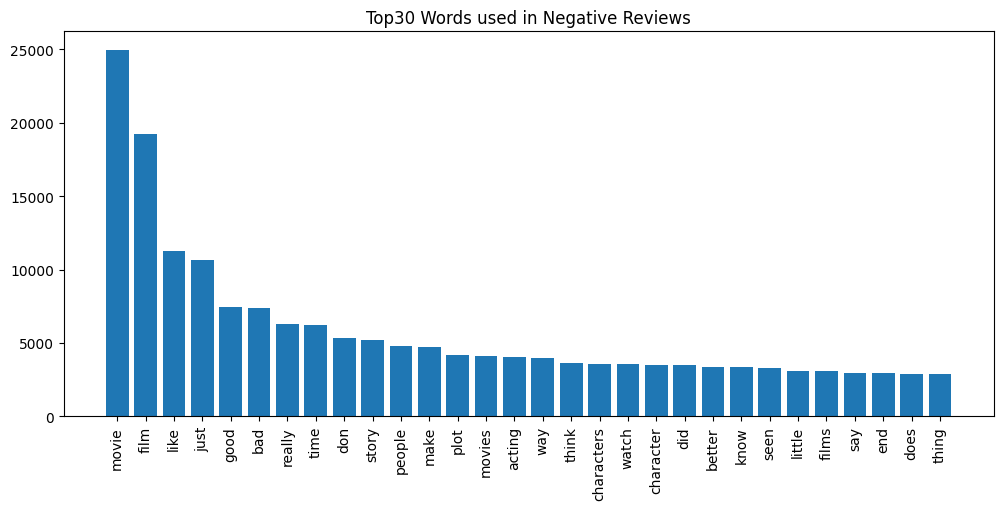

In [13]:
# find top 20 words in negative reviews
train_neg_df = train_df[train_df['label'] == 0]

count_vectorizer = CountVectorizer(analyzer='word', stop_words='english', max_df=0.8 ,min_df=100)
bag_of_words = count_vectorizer.fit_transform(train_neg_df['text'])
sum_words = bag_of_words.sum(axis=0)

words_freq = [
    (word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()
]

words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

x, y = zip(*words_freq[:30])

plt.figure(figsize=(12,5))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title('Top30 Words used in Negative Reviews')
#!mkdir assets
#plt.savefig('assets/Negative_word.webp', bbox_inches='tight')

Text(0.5, 1.0, 'Top30 Words used in Positive Reviews')

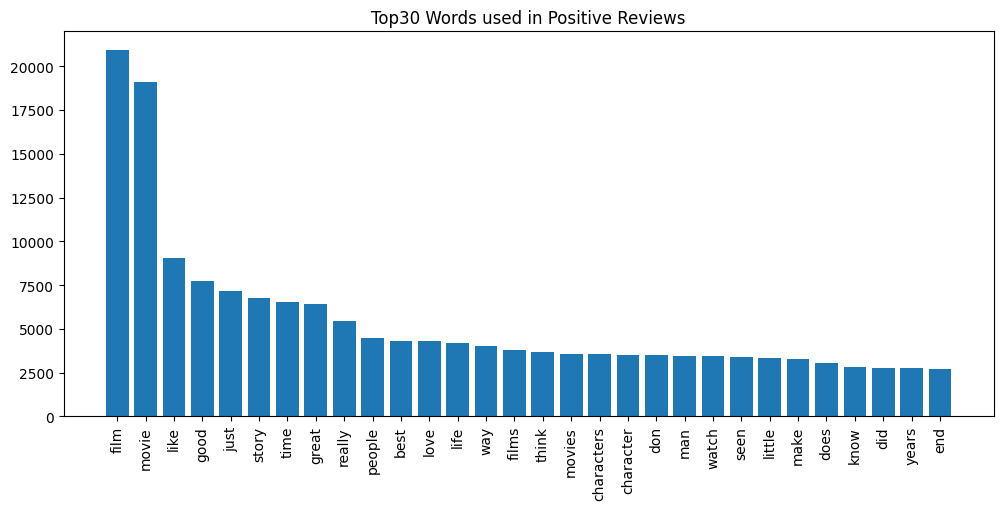

In [14]:
# find top 20 words in positive reviews
train_pos_df = train_df[train_df['label'] == 1]

count_vectorizer = CountVectorizer(analyzer='word', stop_words='english')
bag_of_words = count_vectorizer.fit_transform(train_pos_df['text'])
sum_words = bag_of_words.sum(axis=0)

words_freq = [
    (word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()
]

words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

x, y = zip(*words_freq[:30])

plt.figure(figsize=(12,5))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title('Top30 Words used in Positive Reviews')

#plt.savefig('assets/Positive_words.webp', bbox_inches='tight')

In [15]:
X_rev_train = train_df['text']
y_rev_train = train_df['label']

X_rev_test = test_df['text']
y_rev_test = test_df['label']

In [16]:
#vect = CountVectorizer().fit(X_rev_train)
vect = CountVectorizer(binary=False, max_df=0.80, min_df=10, max_features=10000, stop_words="english").fit(X_rev_train)
#with ngram
#vect = CountVectorizer(binary=False, max_df=0.80, min_df=10, max_features=10000, stop_words="english", ngram_range=(1,2)).fit(X_rev_train)

X_train = vect.transform(X_rev_train)
X_test = vect.transform(X_rev_test)
print("X_train:\n{}".format(repr(X_train)))


X_train:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1944622 stored elements and shape (25000, 10000)>


In [17]:
X_train[0]

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 98 stored elements and shape (1, 10000)>


**Vocabulary:**


In [61]:
#print("Vocabulary: ", vect.vocabulary_)

In [19]:
print("Original review:")
print(X_rev_train[0])
print("\nFirst 20 words that appear in this review (in vocabulary order):")
[print(f"  {w:15} → {c}") for w,c in zip(vect.get_feature_names_out()[X_train[0].indices[:20]], X_train[0].data[:20])];

Original review:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in . I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself. The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. What kills me about I AM CURIOUS-YELLOW is that years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it's 

In [20]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 5010 to 5030:\n{}".format(feature_names[5010:5030]))
print("Every 2000th feature:\n{}".format(feature_names[::1000]))


Number of features: 10000
First 20 features:
['aaron' 'abandon' 'abandoned' 'abbott' 'abc' 'abducted' 'abilities'
 'ability' 'able' 'aboard' 'abominable' 'abomination' 'abortion' 'abound'
 'abraham' 'abroad' 'abrupt' 'abruptly' 'absence' 'absent']
Features 5010 to 5030:
['kudos' 'kumar' 'kung' 'kurosawa' 'kurt' 'kusturica' 'kyle' 'lab' 'label'
 'labeled' 'labor' 'laboratory' 'labyrinth' 'laced' 'lack' 'lacked'
 'lacking' 'lackluster' 'lacks' 'ladder']
Every 2000th feature:
['aaron' 'bothers' 'coup' 'entertains' 'habit' 'korea' 'neglect' 'punk'
 'shawn' 'thelma']


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

scores = cross_val_score(LogisticRegression(), X_train, y_rev_train, cv=3)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.82


CountVectorizer to Extracting Features from Text

https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/

In [22]:
nb_vec = LogisticRegression()
nb_vec.fit(X_train, y_rev_train)
preds = nb_vec.predict(X_test)
print(classification_report(y_rev_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [23]:
#Show weights for BOW
# https://www.nlplanet.org/course-practical-nlp/01-intro-to-nlp/04-n-grams
# create a pandas dataframe that shows the unigrams in each text
keys_values_sorted = sorted(list(vect.vocabulary_.items()), key=lambda t: t[1])
keys_sorted = list(zip(*keys_values_sorted))[0]

# show logistic regression weights
from_unigram_to_weight = dict(zip(keys_sorted, nb_vec.coef_[0]))
from_unigram_to_weight
print('Positive')
sorted(zip(nb_vec.coef_[0].round(3) , keys_sorted) , reverse = True)[:20]


Positive


[(np.float64(1.904), 'refreshing'),
 (np.float64(1.728), 'vengeance'),
 (np.float64(1.611), 'flawless'),
 (np.float64(1.58), 'funniest'),
 (np.float64(1.555), 'wonderfully'),
 (np.float64(1.549), 'cerebral'),
 (np.float64(1.543), 'kurosawa'),
 (np.float64(1.531), 'hooked'),
 (np.float64(1.485), 'erotic'),
 (np.float64(1.414), 'carrey'),
 (np.float64(1.406), 'appreciated'),
 (np.float64(1.399), 'chavez'),
 (np.float64(1.397), 'kitty'),
 (np.float64(1.39), 'shannon'),
 (np.float64(1.384), 'perfectly'),
 (np.float64(1.373), 'marvelous'),
 (np.float64(1.371), 'scariest'),
 (np.float64(1.35), 'delightful'),
 (np.float64(1.344), 'spring'),
 (np.float64(1.343), 'fashioned')]

In [24]:
print('Negative')
sorted(zip(nb_vec.coef_[0].round(2) , keys_sorted) , reverse = False)[:20]

Negative


[(np.float64(-2.45), 'disappointment'),
 (np.float64(-2.41), 'waste'),
 (np.float64(-2.04), 'worst'),
 (np.float64(-1.99), 'poorly'),
 (np.float64(-1.91), 'baldwin'),
 (np.float64(-1.74), 'lacks'),
 (np.float64(-1.71), 'alright'),
 (np.float64(-1.69), 'awful'),
 (np.float64(-1.67), 'boredom'),
 (np.float64(-1.67), 'generous'),
 (np.float64(-1.65), 'unfunny'),
 (np.float64(-1.63), 'forgettable'),
 (np.float64(-1.62), 'mess'),
 (np.float64(-1.61), 'unremarkable'),
 (np.float64(-1.56), 'unlikeable'),
 (np.float64(-1.55), 'refer'),
 (np.float64(-1.55), 'unwatchable'),
 (np.float64(-1.54), 'lifeless'),
 (np.float64(-1.53), 'disappointing'),
 (np.float64(-1.52), 'fails')]

# **TfidfVectorizer**

The TfidfVectorizer is a feature extraction technique in the scikit-learn library for converting a collection of raw text documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features. This is a common step in Natural Language Processing (NLP) and text mining tasks to transform text data into numerical data that machine learning algorithms can work with.

How TfidfVectorizer Works
Term Frequency (TF): This measures how frequently a term (word) appears in a document. The assumption is that the more frequently a term appears in a document, the more important it is. However, this alone can be misleading, as common words (like "the", "is", "and") will appear frequently in many documents.
Inverse Document Frequency (IDF): This measures how important a term is by considering how often it appears across all documents in the dataset. The more documents a term appears in, the less important it is. The IDF value of a term decreases as the number of documents containing the term increases.
TF-IDF: The product of TF and IDF. This score gives us an indication of how important a term is within a particular document while reducing the weight of commonly occurring terms that are less informative.
Formula of TF-IDF
The TF-IDF score for a term t in a document d is calculated as:

tf-idf
(
t
,
d
)
=
tf
(
t
,
d
)
×
idf
tf-idf(t,d)=tf(t,d)×idf

Where:

tf
(
t
,
d
)
tf(t,d)
 is the term frequency of term t in document d.
idf
(
t
)
idf(t)
 is the inverse document frequency of term t, calculated as:
idf
(
t
)
=
log
⁡
(
N
1
+
df
(
t
)
)
idf(t)=log(
1+df(t)
N
​
 )

Where:

N is the total number of documents.
df
(
t
)
df(t)
 is the number of documents containing the term t.
 https://www.geeksforgeeks.org/how-to-store-a-tfidfvectorizer-for-future-use-in-scikit-learn/

 https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/


In [25]:
tfidf_rev_vec = TfidfVectorizer(
    binary=False, max_df=0.80, min_df=10,
    max_features=10000
)

X_rev_tfidf_train = tfidf_rev_vec.fit_transform(X_rev_train)
X_rev_tfidf_test = tfidf_rev_vec.transform(X_rev_test)

In [26]:
# print idf values
df_idf = pd.DataFrame(tfidf_rev_vec.idf_, index=vect.get_feature_names_out(),columns=["idf_weights"])

# sort ascending
df_idf.sort_values(by=['idf_weights'])

,idf_weights
callahan,1.329545
fontaine,1.334898
wish,1.358545
wannabe,1.436006
assassin,1.438917
...,...
delighted,8.728776
shameful,8.728776
wives,8.728776
decapitated,8.728776


In [27]:
nb_rev = LogisticRegression()
nb_rev.fit(X_rev_tfidf_train, y_rev_train)

LogisticRegression()

In [28]:
preds = nb_rev.predict(X_rev_tfidf_test)
print(classification_report(y_rev_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



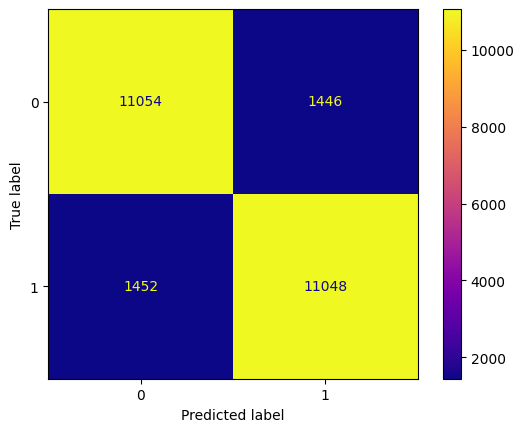

In [29]:
conf_mtx = confusion_matrix(y_rev_test, preds)
conf_mtx_plot = ConfusionMatrixDisplay(
     confusion_matrix=conf_mtx
)
conf_mtx_plot.plot(cmap='plasma')

In [30]:
#Show weights for BOW
# https://www.nlplanet.org/course-practical-nlp/01-intro-to-nlp/04-n-grams
# create a pandas dataframe that shows the unigrams in each text
keys_values_sorted = sorted(list(tfidf_rev_vec.vocabulary_.items()), key=lambda t: t[1])
keys_sorted = list(zip(*keys_values_sorted))[0]

# show logistic regression weights
from_unigram_to_weight = dict(zip(keys_sorted, nb_rev.coef_[0]))
from_unigram_to_weight
print('Positive')
sorted(zip(nb_rev.coef_[0] , keys_sorted) , reverse = True)[:20]

Positive


[(np.float64(6.859046628512368), 'great'),
 (np.float64(6.269594236477708), 'excellent'),
 (np.float64(5.09419575335438), 'perfect'),
 (np.float64(4.894245892654859), 'best'),
 (np.float64(4.743441060688801), 'wonderful'),
 (np.float64(4.2554360059112835), 'amazing'),
 (np.float64(3.851792227098263), 'loved'),
 (np.float64(3.8425509646278373), 'well'),
 (np.float64(3.829348766803211), 'today'),
 (np.float64(3.720460202680055), 'favorite'),
 (np.float64(3.6685999560795435), 'fun'),
 (np.float64(3.5611442463306675), 'enjoyed'),
 (np.float64(3.470452586414351), 'brilliant'),
 (np.float64(3.4542320237719157), 'highly'),
 (np.float64(3.451296255021287), 'love'),
 (np.float64(3.4093979547934326), 'superb'),
 (np.float64(3.145663620534347), 'definitely'),
 (np.float64(3.094385625270183), 'bit'),
 (np.float64(3.0925730436202263), 'enjoyable'),
 (np.float64(3.0063323469429766), 'liked')]

In [31]:
print('Negative')
sorted(zip(nb_rev.coef_[0] , keys_sorted) , reverse = False)[:20]

Negative


[(np.float64(-9.206113763124822), 'worst'),
 (np.float64(-7.028229276899225), 'bad'),
 (np.float64(-6.468450004019749), 'awful'),
 (np.float64(-6.360777948068836), 'waste'),
 (np.float64(-5.839689043962096), 'boring'),
 (np.float64(-5.394455387337588), 'poor'),
 (np.float64(-4.598887933793245), 'terrible'),
 (np.float64(-4.556231781688027), 'nothing'),
 (np.float64(-4.389670199662272), 'worse'),
 (np.float64(-4.3747328970141055), 'dull'),
 (np.float64(-4.310900254913018), 'poorly'),
 (np.float64(-4.156287779744607), 'horrible'),
 (np.float64(-4.15371344684996), 'unfortunately'),
 (np.float64(-3.896114958276368), 'no'),
 (np.float64(-3.870652067696399), 'annoying'),
 (np.float64(-3.7784165919311112), 'disappointment'),
 (np.float64(-3.7360759630977705), 'disappointing'),
 (np.float64(-3.702038136601071), 'ridiculous'),
 (np.float64(-3.6569972484581115), 'stupid'),
 (np.float64(-3.623863208440562), 'fails')]

# **Let's build a pipline**

In [32]:
from sklearn.naive_bayes import BernoulliNB
#('clf', LogisticRegression(solver='lbfgs')),])
#('clf', DecisionTreeClassifier(max_depth=35))])

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english',max_features=10000,ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(fit_intercept=True))])

In [33]:
text_clf.fit(X_rev_train, y_rev_train)
text_clf.score(X_rev_test,y_rev_test)

0.88204

In [34]:
print(text_clf.predict(['false awful we we bla bla bla great great']))
print(text_clf.predict_proba(['false awful we we bla bla bla great great']))

[1]
[[0.39101078 0.60898922]]


# **Let's add PCA/SVD to our features**

In [35]:
from sklearn.decomposition import TruncatedSVD

text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=500, random_state=42)),  # no need to densify!
    ('clf', LogisticRegression(fit_intercept=True))
])

In [36]:
text_clf.fit(X_rev_train, y_rev_train)
text_clf.score(X_rev_test,y_rev_test)

0.87308

In [37]:
print(text_clf.predict(['false awful we we bla bla bla great great']))
print(text_clf.predict_proba(['false awful we we bla bla bla great great']))

[1]
[[0.3673541 0.6326459]]


# Vocabulary Stemmer and Lemmatization

In [62]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

nltk.download('wordnet')
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
nltk.download('stopwords')
stop_words = stopwords.words('english')
# Download required data
nltk.download('punkt')


# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = nltk.corpus.stopwords.words('english')

def stem_tokenizer(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    tokens = text.split()
    return [stemmer.stem(token) for token in tokens if token not in stop_words]

pipelineSGD = Pipeline([
    ('vectorizer', CountVectorizer(
        tokenizer=stem_tokenizer,
        ngram_range=(1, 2),
        lowercase=False  # we already lowercased in tokenizer
    )),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', alpha=1e-4, max_iter=100, random_state=42))
])

pipelineSGD.fit(X_rev_train, y_rev_train)

y_predSGD = pipelineSGD.predict(X_rev_test)
print("Predicted: ", y_predSGD)

print("Accuracy: ", metrics.accuracy_score(y_rev_test, y_predSGD)*100, "%")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Predicted:  [0 0 0 ... 1 0 1]
Accuracy:  88.42 %


In [71]:
text = "DONT WATCH THIS MOVIE. its a complete trash"
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
CLEAN = re.compile("<.*?>")    # to remove everything between "<>"
result = re.sub(CLEAN, " ", text)
result = re.sub("[^a-zA-Z]" , " " , result)
result = result.lower()
result = result.split()   # to break sentences into words
word = [ps.stem(word) for word in result if word not in stopwords.words("english")]
result = " ".join(word)
print(result)
print(pipelineSGD.predict([text]))

dont watch movi complet trash
[0]


# The pipeline examples

In [68]:
from sklearn.svm import LinearSVC

pipelineSVM = Pipeline([
    ('vectorizer', CountVectorizer(stop_words = stop_words, ngram_range = (1,2), max_features = None)),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(C = 0.5, max_iter = 1000, penalty = 'l2', tol = 0.01))
])


pipelineSVM.fit(X_rev_train, y_rev_train)

y_predSVM = pipelineSVM.predict(X_rev_test)
print("Predicted: ", y_predSVM)

print("Accuracy: ", metrics.accuracy_score(y_rev_test, y_predSVM)*100, "%")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Predicted:  [0 0 0 ... 1 0 1]
Accuracy:  88.90400000000001 %


In [40]:
text_clf = Pipeline([('vect', CountVectorizer(analyzer='word', token_pattern=r'\w{2,}',  strip_accents='unicode', stop_words=stop_words, max_features=10000,ngram_range=(1,1))),
                     ('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression()),])
text_clf.fit(X_rev_train, y_rev_train)
text_clf.score(X_rev_test,y_rev_test)

0.88408

In [41]:
# Most common words that were used in positive reviews
#https://github.com/Kasra1377/IMDB-sentiment-analysis/blob/master/data-preprocessing.ipynb
features = text_clf['vect'].get_feature_names_out()
sorted(zip(text_clf['clf'].coef_[0] , features) , reverse = True)[:20]


[(np.float64(6.486055336229315), 'great'),
 (np.float64(6.06467404851868), 'excellent'),
 (np.float64(4.876131052748819), 'perfect'),
 (np.float64(4.808378194855225), 'best'),
 (np.float64(4.645462888146326), 'wonderful'),
 (np.float64(4.100150541882259), 'amazing'),
 (np.float64(4.05885474165937), 'favorite'),
 (np.float64(3.744981700664376), 'well'),
 (np.float64(3.6896923673989432), 'loved'),
 (np.float64(3.5891560418036668), 'highly'),
 (np.float64(3.572892934547749), 'enjoyed'),
 (np.float64(3.5583019667385583), 'today'),
 (np.float64(3.504338281206992), 'love'),
 (np.float64(3.430370590856032), 'fun'),
 (np.float64(3.418824931861892), 'superb'),
 (np.float64(3.3711382163566617), 'brilliant'),
 (np.float64(3.2587722962655237), 'enjoyable'),
 (np.float64(3.1904817225771827), 'definitely'),
 (np.float64(3.078571476640152), 'fantastic'),
 (np.float64(2.9904792782104686), 'bit')]

In [42]:
# Most common words that were used in negative reviews
sorted(zip(text_clf['clf'].coef_[0] , features))[:20]

[(np.float64(-9.129276817190497), 'worst'),
 (np.float64(-6.831288563266321), 'bad'),
 (np.float64(-6.620732528032114), 'awful'),
 (np.float64(-6.583789982393652), 'waste'),
 (np.float64(-5.734153731571165), 'boring'),
 (np.float64(-5.268817027284607), 'poor'),
 (np.float64(-4.709353890162201), 'worse'),
 (np.float64(-4.695993004057011), 'nothing'),
 (np.float64(-4.620902155790146), 'terrible'),
 (np.float64(-4.518074919316939), 'poorly'),
 (np.float64(-4.457961456119334), 'dull'),
 (np.float64(-4.373552942827874), 'horrible'),
 (np.float64(-4.226414492981693), 'disappointment'),
 (np.float64(-4.215365695897459), 'unfortunately'),
 (np.float64(-3.952933978228467), 'supposed'),
 (np.float64(-3.94901448005584), 'annoying'),
 (np.float64(-3.9067857608102754), 'disappointing'),
 (np.float64(-3.801641422347446), 'fails'),
 (np.float64(-3.789886093720776), 'ridiculous'),
 (np.float64(-3.708145132765208), 'mess')]

Examining the Model Performance

In [43]:

text = "DONT WATCH THIS MOVIE. its a complete trash"

In [69]:
#evaluate original and stemmed
print(text_clf.predict_proba([text]))

[[0.14411723 0.85588277]]


# **The best sklearn result**

In [46]:
#https://www.kaggle.com/code/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS.union(["book"])

pipe = make_pipeline(TfidfVectorizer(
                                    stop_words='english',
                                    strip_accents='unicode',
                                    token_pattern=r'\w{1,}', #accept tokens that have 1 or more characters
                                    analyzer='word',
                                    ngram_range=(1, 2),
                                    min_df=100),
                     LinearSVC(C = 0.5, max_iter = 1000, penalty = 'l2', tol = 0.01))
param_grid = {'tfidfvectorizer__max_features': [None],
              'tfidfvectorizer__sublinear_tf': [True],
              'tfidfvectorizer__smooth_idf': [True],
              'tfidfvectorizer__use_idf': [True],
              'tfidfvectorizer__stop_words': [None],
              'linearsvc__C': [ 0.1],

             }
grid = GridSearchCV(pipe, param_grid, cv=3)

grid3 = grid.fit(X_rev_train, y_rev_train)



In [47]:
print(grid3.best_params_)
print(grid3.best_score_)


{'linearsvc__C': 0.1, 'tfidfvectorizer__max_features': None, 'tfidfvectorizer__smooth_idf': True, 'tfidfvectorizer__stop_words': None, 'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__use_idf': True}
0.8825600444224152


In [48]:
grid3.score(X_rev_test,y_rev_test)

0.89616

In [49]:
# for the comparition best results:
# https://paperswithcode.com/sota/sentiment-analysis-on-imdb

In [50]:
print(grid3.predict(['ok recommended its greate 10 of 10 movie']))

[1]


In [51]:
y_pred=grid3.predict(X_rev_test)

In [52]:
print("Accuracy: ", metrics.accuracy_score(y_rev_test, y_pred)*100, "%")

Accuracy:  89.616 %


In [53]:
y_test = np.asarray(y_rev_test)
misclassified = np.where(y_test != grid3.predict(X_rev_test))
len(misclassified[0])

2596

In [54]:
i=200
print('True label=',y_test[misclassified[0][i]], ' predicted =', 1-y_test[misclassified[0][i]] )
X_rev_test[misclassified[0][i]]


True label= 0  predicted = 1


'This movie seems a little clunky around the edges, like not quite enough zaniness was thrown it when it should have been. But I mostly enjoyed it.<br /><br />The storyline is more than a little bit preposterous, so no expectation of "something real" should be included in your viewing experience. Check your brain in at the door. It will not be needed and might be an impediment otherwise.<br /><br />I quite enjoyed Clennon\'s performance as the real Dr. Baird. His role was spot on for giving Aykroyd\'s character a protagonist. What a putz the real Dr. Baird was.<br /><br />And Matthau was quite good as the lead character\'s sidekick. Annoying at first, but ultimately lovable. Sort of. Kind of. Or at least something the use of a bar of soap and a lot of water would have been more than helpful.<br /><br />Actually worth watching? If you\'re in the mood for a spoof on the psychiatric profession, sure, why not.'

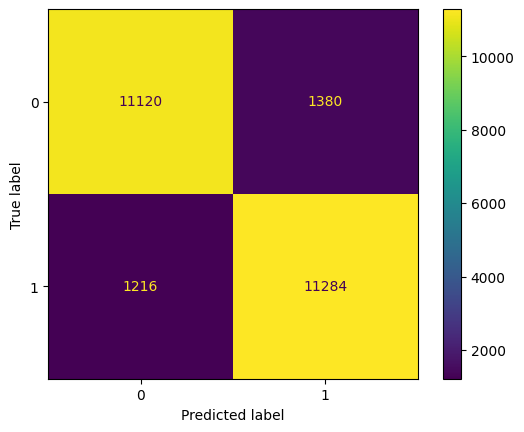

In [55]:
cm=confusion_matrix(y_test, grid3.predict(X_rev_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid3.classes_)
disp.plot()
plt.show()

# Let's cluster train part of DB

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import pandas as pd

# 1. Very light vectorizer (we just want to catch duplicates/spam)
vect = TfidfVectorizer(
    ngram_range=(1,3),          # trigrams catch entire spam sentences!
    max_features=20000,
    min_df=3,
    stop_words='english',
    lowercase=True
)

X = vect.fit_transform(X_rev_train)   # X_rev_train = list/array of raw reviews

# 2. Cluster into 50–200 clusters (MiniBatchKMeans is fast on 50k docs)
n_clusters = 100
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
labels = kmeans.fit_predict(X)

# 3. Show the biggest clusters → spam jumps out immediately
cluster_sizes = np.bincount(labels)
biggest_clusters = np.argsort(cluster_sizes)[::-1]

print("Top 10 biggest clusters (these are almost always spam):")
for i in biggest_clusters[:10]:
    size = cluster_sizes[i]
    print(f"\nCluster {i} → {size} reviews ({size/len(X_rev_train)*100:.1f}%)")

    # Show 3 example reviews from this cluster
    examples_idx = np.where(labels == i)[0][:3]
    for j, idx in enumerate(examples_idx, 1):
        text = X_rev_train[idx]
        print(f"   {j}. \"{text.replace(chr(10), ' ')[:180]}...\"")

Top 10 biggest clusters (these are almost always spam):

Cluster 44 → 12932 reviews (51.7%)
   1. "I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in . I also heard that at first it was seized by U.S. ..."
   2. ""I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As..."
   3. "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story. One might feel virtuous for sitting thru it because it..."

Cluster 55 → 6843 reviews (27.4%)
   1. "Who are these "They"- the actors? the filmmakers? Certainly couldn't be the audience- this is among the most air-puffed productions in existence. It's the kind of movie that looks ..."
   2. "Today I found "They All Laughed" on VHS on sale in a rental. It was a really old and very used VHS

In [57]:
def filter_keywords(X_rev_train, labels, cluster, n_keep=3) -> str:
    mask = (labels == cluster)
    text = ". ".join(X_rev_train.loc[mask].astype(str))
    kw_model = KeyBERT()
    candidates = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1),
                                      top_n=n_keep*2)
    #print(candidates)
    keywords_with_scores = candidates  # already a list of tuples

    # 4. Greedily select non-overlapping keywords
    selected = []
    for kw, score in keywords_with_scores:
        if any(kw in seen for seen in selected):
            continue
        if any(seen in kw for seen in selected):
            continue
        selected.append(kw)
        if len(selected) >= n_keep:
            break

    # 5. Return pretty string
    if len(selected) > 1:
        return (", ".join(selected[:-1]) + " and " + selected[-1]).capitalize()
    elif selected:
        return selected[0].capitalize()
    else:
        return "No keywords"

In [58]:
def filter_keywords_in_text(text_to_analize, n_keep=3) -> str:

    text = ". ".join(text_to_analize.astype(str))
    kw_model = KeyBERT()
    candidates = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1),
                                      top_n=n_keep*2)
    #print(candidates)
    keywords_with_scores = candidates  # already a list of tuples

    # 4. Greedily select non-overlapping keywords
    selected = []
    for kw, score in keywords_with_scores:
        if any(kw in seen for seen in selected):
            continue
        if any(seen in kw for seen in selected):
            continue
        selected.append(kw)
        if len(selected) >= n_keep:
            break

    # 5. Return pretty string
    if len(selected) > 1:
        return (", ".join(selected[:-1]) + " and " + selected[-1]).capitalize()
    elif selected:
        return selected[0].capitalize()
    else:
        return "No keywords"

In [59]:
keywords = filter_keywords(X_rev_train, labels, cluster=27, n_keep=3)
print(keywords)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Pinjar, bollywood and hindi


In [60]:

print("Top 40 biggest clusters (these are almost always spam):")
for i in biggest_clusters[:40]:
    size = cluster_sizes[i]
    print(f"\nCluster {i} → {size} reviews ({size/len(X_rev_train)*100:.1f}%) Keywords: ", filter_keywords(X_rev_train, labels, cluster=i, n_keep=3))

    # Show 3 example reviews from this cluster
    examples_idx = np.where(labels == i)[0][:5]
    for j, idx in enumerate(examples_idx, 1):
        text = X_rev_train[idx]
        print(f"   {j}. \"{text.replace(chr(10), ' ')[:180]}...\"")

Top 40 biggest clusters (these are almost always spam):

Cluster 44 → 12932 reviews (51.7%) Keywords:  Nudity, pornographic and pornography
   1. "I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in . I also heard that at first it was seized by U.S. ..."
   2. ""I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As..."
   3. "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story. One might feel virtuous for sitting thru it because it..."
   4. "This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead. The film has two strong elements and those are, () the realistic acting () th..."
   5. "Oh, brother...after hearing about this ridiculous film for umpteen years all I can th